# Cell state x motif plot

Plot showing which motifs were extracted from each cell type (for the curated motif set).

Inputs:
1. Cluster config
2. One file per cell state with motif annotation and number of seqlets.

In [1]:
library(ggplot2)
library(dplyr)
library(scales)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Load inputs

In [2]:
STATE_ORDER = rev(c("Rod", 
                "OFFconebipolar", 
                "Mullerglia",
                "ONconebipolar",
                "Rodbipolar",
                "Cone",
                "GABAamacrine",
                "Horizontal",
                "Glyamacrine",
                "Retinalganglioncell",
                "AIIamacrine",
                "Astrocyte",
                "Microglia"))

### Per cell state annotated MoDISco motifs

In [3]:
modisco_annotated = list()

for (i in STATE_ORDER) {
    modisco_annotated[[i]] = read.table(sprintf("./tomtom/%s.txt", i), 
                                        sep='\t', 
                                        header=T,
                                       stringsAsFactors=F)
    
}

head(modisco_annotated[[1]])

,Pattern,num_seqlets,match_1,q.value
,<chr>,<int>,<chr>,<dbl>
1,pattern_0,7396,CTCF,0.00000e+00
2,pattern_1,4759,OTX:-1:OTX,2.17350e-08
3,pattern_2,4731,SP,2.19711e-36
4,pattern_3,3301,SPI,8.70195e-30
5,pattern_4,3129,NFY,2.60128e-19
6,pattern_5,3048,CREB,5.46409e-20


## Plot

Motifs with ":" are dimers of 30 curated motifs, which can be ignored for now.

Multiple patterns can match to the same motif.

In [4]:
QVAL = 0.05

In [5]:
motif_names = c()

for (i in STATE_ORDER) {
    motif_names = c(motif_names , modisco_annotated[[i]]$match_1)
}
motif_names = rev(sort(table(motif_names)))

In [6]:
motif_names

motif_names
           NRF            PAX          ZNF76            ETS           CREB 
            25             23             19             19             15 
           YY1             SP           CTCF            NFY          RFX/1 
            14             14             14             13             12 
            NR            NFI            MEF BHLH(CACGTGAC)     OTX:-1:OTX 
            12             12             12             12             11 
          NFIL          KAISO   BHLH(CAGMTG)      OTX:2:OTX      OTX:4:OTX 
            11             10              8              7              6 
     OTX:3:OTX           AP-1            OTX HOMEOBOX:TAAGC           TFAP 
             6              6              5              4              3 
       SOX:SOX          RFX/2            LHX  HOMEOBOX:MEIS            SPI 
             3              3              3              3              2 
     OTX:0:OTX         ONECUT            MAZ        LHX:LHX            ATF 


In [7]:
MOTIF_SUBSET = read.table("../20241103_motif_consolidation/tfs_final_w_rep.tsv", stringsAsFactor=F)$V4

In [8]:
filtered_modisco = list()

for (i in STATE_ORDER) {
    cur = modisco_annotated[[i]]
    cur = cur[cur$q.value < QVAL, ]
    cur$frac = cur$num_seqlets/sum(cur$num_seqlets)
    cur = cur[cur$match_1 %in% MOTIF_SUBSET, c("frac", "match_1")]
    cur = cur %>% group_by(match_1) %>% summarize_all(sum)
    cur$log10_frac = log10(cur$frac)
    
    filtered_modisco[[i]] = cur
}

In [9]:
plot_df = data.frame()

for (i in STATE_ORDER) {
    cur = filtered_modisco[[i]]
    cur$state = i
    
    plot_df = rbind(plot_df, cur)
}

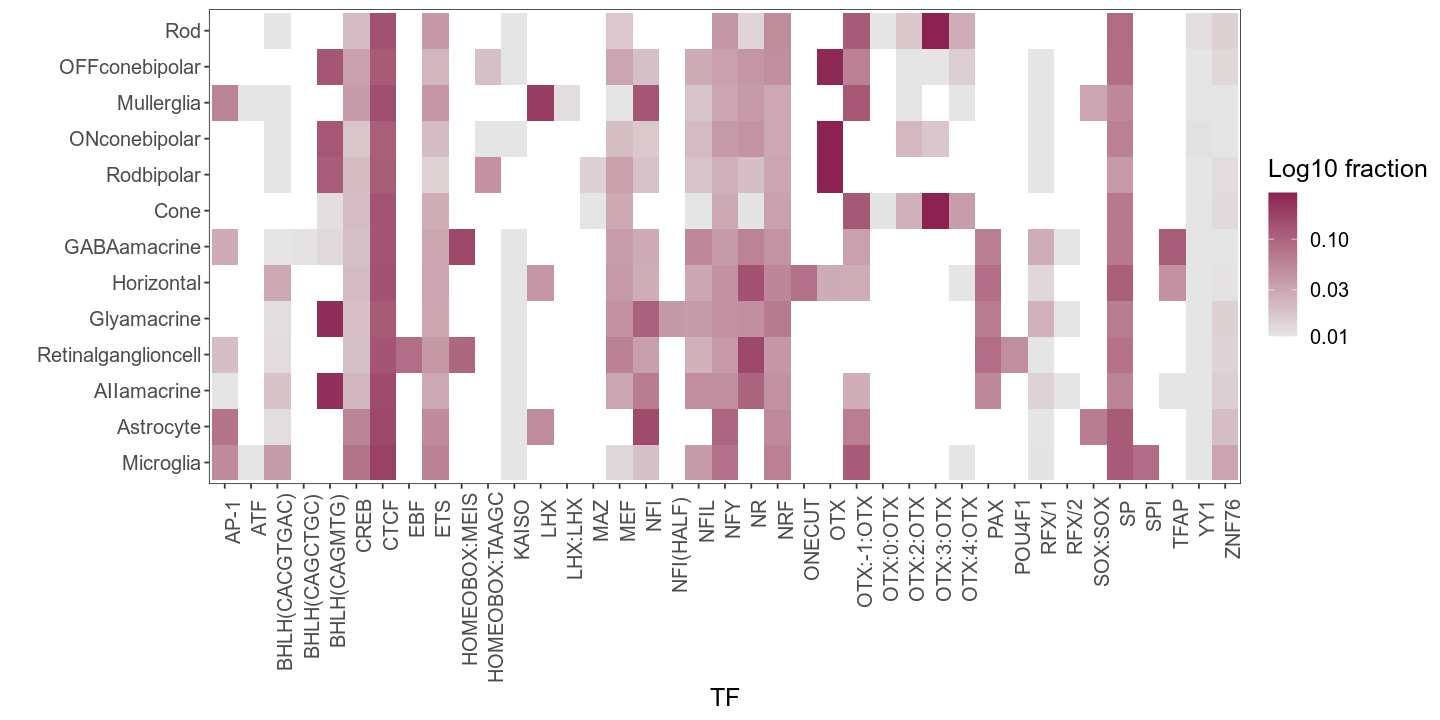

In [10]:
options(repr.plot.width = 12, repr.plot.height = 6)

ggplot(plot_df) +
geom_tile(aes(x=match_1, y=factor(state, levels=STATE_ORDER), fill=frac)) +
scale_fill_gradient(low="gray90",
                      high="violetred4",
                      limits=c(0.01, 0.3),
                      oob=squish,
                      trans='log10', 
                      name="Log10 fraction") +
xlab("TF") +
ylab("") +
theme_bw() +
theme(axis.text.x = element_text(angle = 90, hjust=0.95), # rotate TF text
      strip.background = element_blank(),
      panel.grid.major = element_blank(),
          text = element_text(size=15)) 

Order for TFs based on similarity

In [11]:
head(plot_df)

match_1,frac,log10_frac,state
<chr>,<dbl>,<dbl>,<chr>
AP-1,0.049122370,-1.3087207,Microglia
ATF,0.003485622,-2.4577197,Microglia
BHLH(CACGTGAC),0.037520229,-1.4257345,Microglia
CREB,0.075886966,-1.1198328,Microglia
CTCF,0.184140421,-0.7348509,Microglia
ETS,0.058583344,-1.2322258,Microglia


In [12]:
plot_df[1, ]$match_1

[1] "AP-1"

In [13]:
which(MOTIF_SUBSET == plot_df[1, "match_1"])

integer(0)

In [14]:
which(MOTIF_SUBSET == "CTCF")

[1] 2

In [15]:
plot_df[3, ]

match_1,frac,log10_frac,state
<chr>,<dbl>,<dbl>,<chr>
BHLH(CACGTGAC),0.03752023,-1.425735,Microglia


In [16]:
log10_matrix = matrix(1, length(MOTIF_SUBSET), length(STATE_ORDER))

log10_matrix = (min(plot_df$log10_frac) - 1)*log10_matrix

for (i in seq(nrow(plot_df))) {
    log10_matrix[which(MOTIF_SUBSET == plot_df[i, ]$match_1), as.numeric(factor(plot_df[i,]$state, levels=STATE_ORDER))] = plot_df[i,]$log10_frac
}

log10_matrix = t(log10_matrix)

# will use this for re-ordering on membership matrix

In [17]:
membership_matrix = matrix(0, length(MOTIF_SUBSET), length(STATE_ORDER))

for (i in seq(nrow(plot_df))) {
    membership_matrix[which(MOTIF_SUBSET == plot_df[i, ]$match_1), as.numeric(factor(plot_df[i,]$state, levels=STATE_ORDER))] = 1 
}

membership_matrix = t(membership_matrix)

In [18]:
tf_hclust = hclust(dist(t(membership_matrix), method = "euclidean"), method = "ward.D") # trying to order by membership
tf_dendro = as.dendrogram(tf_hclust)
# tf_dendro = reorder(tf_dendro, colSums(log10_matrix* seq(1,length(MOTIF_SUBSET)))/colSums(log10_matrix))
tf_dendro = reorder(tf_dendro, colSums(membership_matrix))
tf_order = as.hclust(tf_dendro)$order

In [19]:
tf_order

[1] 22 25 29 39 31 34  7 11 30  3 27 13 23 18  8 35 28 12 36 32 37 14 38 26 33
[26] 24  5 20 16  6 10 21 19 17 15  9  4  1  2

In [20]:
MOTIF_SUBSET[tf_order]

[1] "EBF"            "POU4F1"         "BHLH(CAGCTGC)"  "HOMEOBOX:MEIS" 
 [5] "ONECUT"         "NFI(HALF)"      "SPI"            "ATF"           
 [9] "LHX:LHX"        "SOX:SOX"        "LHX"            "AP-1"          
[13] "TFAP"           "RFX/2"          "PAX"            "OTX:4:OTX"     
[17] "OTX:-1:OTX"     "MAZ"            "OTX:0:OTX"      "OTX:3:OTX"     
[21] "OTX:2:OTX"      "BHLH(CAGMTG)"   "HOMEOBOX:TAAGC" "OTX"           
[25] "NFIL"           "NR"             "MEF"            "KAISO"         
[29] "BHLH(CACGTGAC)" "RFX/1"          "NFI"            "NRF"           
[33] "ETS"            "CREB"           "YY1"            "SP"            
[37] "NFY"            "ZNF76"          "CTCF"

In [21]:
# manual adjustements
# move OTX:OTX together 
# bring TFAP2 before SPI (since it's exclusive)

In [22]:
length(tf_order)

[1] 39

In [23]:
# tf_order = tf_order[c(c(1,3,4,5,2), 6:9, 17, 10:16, 18:29)]

In [25]:
MOTIF_SUBSET[tf_order]

[1] "EBF"            "POU4F1"         "BHLH(CAGCTGC)"  "HOMEOBOX:MEIS" 
 [5] "ONECUT"         "NFI(HALF)"      "SPI"            "ATF"           
 [9] "LHX:LHX"        "SOX:SOX"        "LHX"            "AP-1"          
[13] "TFAP"           "RFX/2"          "PAX"            "OTX:4:OTX"     
[17] "OTX:-1:OTX"     "MAZ"            "OTX:0:OTX"      "OTX:3:OTX"     
[21] "OTX:2:OTX"      "BHLH(CAGMTG)"   "HOMEOBOX:TAAGC" "OTX"           
[25] "NFIL"           "NR"             "MEF"            "KAISO"         
[29] "BHLH(CACGTGAC)" "RFX/1"          "NFI"            "NRF"           
[33] "ETS"            "CREB"           "YY1"            "SP"            
[37] "NFY"            "ZNF76"          "CTCF"

In [26]:
tf_order

[1] 22 25 29 39 31 34  7 11 30  3 27 13 23 18  8 35 28 12 36 32 37 14 38 26 33
[26] 24  5 20 16  6 10 21 19 17 15  9  4  1  2

In [27]:
length(tf_order)

[1] 39

In [28]:
MOTIF_SUBSET[tf_order]

[1] "EBF"            "POU4F1"         "BHLH(CAGCTGC)"  "HOMEOBOX:MEIS" 
 [5] "ONECUT"         "NFI(HALF)"      "SPI"            "ATF"           
 [9] "LHX:LHX"        "SOX:SOX"        "LHX"            "AP-1"          
[13] "TFAP"           "RFX/2"          "PAX"            "OTX:4:OTX"     
[17] "OTX:-1:OTX"     "MAZ"            "OTX:0:OTX"      "OTX:3:OTX"     
[21] "OTX:2:OTX"      "BHLH(CAGMTG)"   "HOMEOBOX:TAAGC" "OTX"           
[25] "NFIL"           "NR"             "MEF"            "KAISO"         
[29] "BHLH(CACGTGAC)" "RFX/1"          "NFI"            "NRF"           
[33] "ETS"            "CREB"           "YY1"            "SP"            
[37] "NFY"            "ZNF76"          "CTCF"

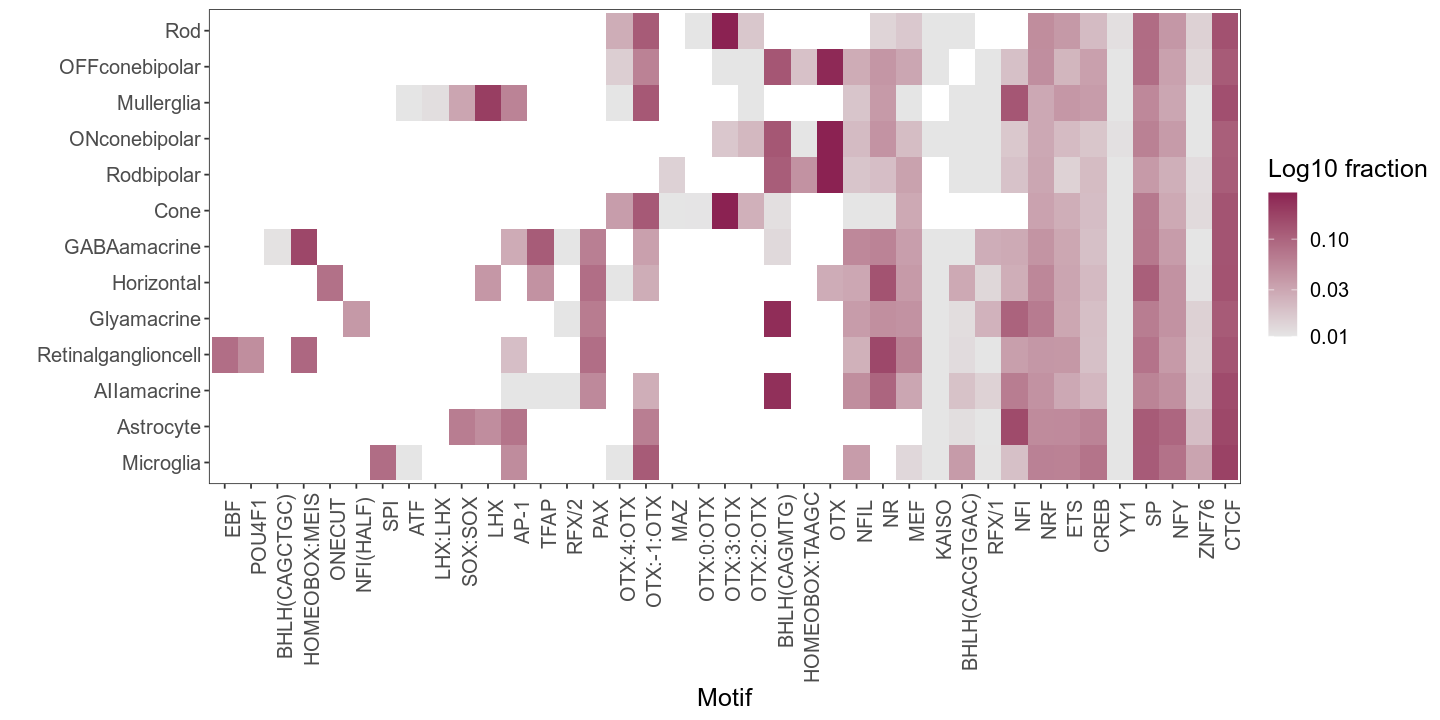

In [29]:
options(repr.plot.width = 12, repr.plot.height = 6)

ggplot(plot_df) +
geom_tile(aes(x=factor(match_1, levels=MOTIF_SUBSET[tf_order]), y=factor(state, levels=STATE_ORDER), fill=frac)) +
scale_fill_gradient(low="gray90",
                      high="violetred4",
                      limits=c(0.01, 0.3),
                      oob=squish,
                      trans='log10', 
                      name="Log10 fraction") +
xlab("Motif") +
ylab("") +
theme_bw() +
theme(axis.text.x = element_text(angle = 90, hjust=0.95), # rotate TF text
      strip.background = element_blank(),
      panel.grid.major = element_blank(),
          text = element_text(size=15)) 

In [30]:
ggsave("./figs/motif_x_cell_state.pdf", height=6, width=12, useDingbats=F)